<a href="https://colab.research.google.com/github/MJ10/GANs/blob/master/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plot
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
batch_size = 32
X_dim = 784
z_dim = 10
h_dim = 128
lambda_grad = 10
lr = 0.0001
n_disc = 5

In [3]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

In [0]:
def plot_images(samples):
    fig = plot.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [0]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
# D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# D_W2 = tf.Variable(xavier_init([h_dim, 1]))
# D_b2 = tf.Variable(tf.zeros(shape=[1]))

# theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

# G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
# G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# theta_G = [G_W1, G_W2, G_b1, G_b2]

In [0]:
def get_sample_z(size):
    return np.random.uniform(-1., 1., size=size)

In [0]:
def generator(z):
    with tf.variable_scope('generator') as scope:
        G_h1 = tf.layers.dense(z, units=h_dim, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        G_out = tf.nn.sigmoid(tf.layers.dense(G_h1, units=X_dim, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer()))
        return G_out

In [0]:
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        D_h1 = tf.layers.dense(x, units=h_dim, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        D_out = tf.layers.dense(D_h1, units=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        return D_out

In [0]:
generator_sample = generator(z)
discriminator_real = discriminator(X)
discriminator_fake = discriminator(generator_sample, True)

In [0]:
epsilon = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
interpolated = epsilon * X + (1 - epsilon) * generator_sample
grads = tf.gradients(discriminator(interpolated, True), [interpolated])[0]
grad_norm = tf.sqrt(tf.reduce_sum((grads) ** 2, axis=1))
gp = lambda_grad * tf.reduce_mean((grad_norm - 1) ** 2)

In [0]:
d_loss = tf.reduce_mean(discriminator_fake) - tf.reduce_mean(discriminator_real) + gp
g_loss = -tf.reduce_mean(discriminator_fake)

In [0]:
g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
d_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

d_step = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(d_loss, var_list=d_vars))
g_step = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(g_loss, var_list=g_vars))

In [13]:
print(g_vars)

[<tf.Variable 'generator/dense/kernel:0' shape=(10, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>]


In [14]:
print(d_vars)

[<tf.Variable 'discriminator/dense/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'discriminator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/bias:0' shape=(1,) dtype=float32_ref>]


In [0]:
sess = tf.InteractiveSession()

In [0]:
sess.run(tf.global_variables_initializer())

Iteration: 0 - Discriminator Loss: -0.5962, Generator Loss: 1.274


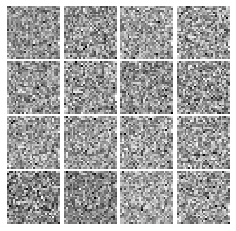

Iteration: 100 - Discriminator Loss: 14.8, Generator Loss: 19.65
Iteration: 200 - Discriminator Loss: 13.94, Generator Loss: 18.1
Iteration: 300 - Discriminator Loss: 12.74, Generator Loss: 15.86
Iteration: 400 - Discriminator Loss: 11.77, Generator Loss: 13.56
Iteration: 500 - Discriminator Loss: 10.14, Generator Loss: 10.98
Iteration: 600 - Discriminator Loss: 8.738, Generator Loss: 8.703
Iteration: 700 - Discriminator Loss: 7.759, Generator Loss: 6.586
Iteration: 800 - Discriminator Loss: 6.648, Generator Loss: 4.638
Iteration: 900 - Discriminator Loss: 5.823, Generator Loss: 2.883
Iteration: 1000 - Discriminator Loss: 5.479, Generator Loss: 1.46


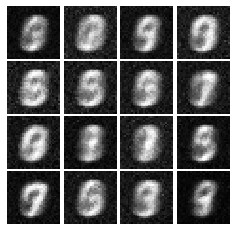

Iteration: 1100 - Discriminator Loss: 5.089, Generator Loss: 0.9048
Iteration: 1200 - Discriminator Loss: 4.278, Generator Loss: 0.2089
Iteration: 1300 - Discriminator Loss: 4.511, Generator Loss: 0.004905
Iteration: 1400 - Discriminator Loss: 4.468, Generator Loss: -0.4054
Iteration: 1500 - Discriminator Loss: 3.745, Generator Loss: -0.4051
Iteration: 1600 - Discriminator Loss: 3.86, Generator Loss: -0.5035
Iteration: 1700 - Discriminator Loss: 3.622, Generator Loss: -0.4157
Iteration: 1800 - Discriminator Loss: 3.442, Generator Loss: -0.4325
Iteration: 1900 - Discriminator Loss: 3.431, Generator Loss: -0.3788
Iteration: 2000 - Discriminator Loss: 3.205, Generator Loss: -0.6147


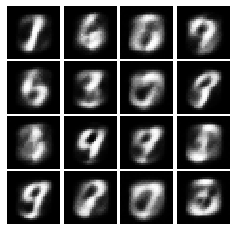

Iteration: 2100 - Discriminator Loss: 3.211, Generator Loss: -0.5069
Iteration: 2200 - Discriminator Loss: 2.872, Generator Loss: -0.4797
Iteration: 2300 - Discriminator Loss: 2.783, Generator Loss: -0.3793
Iteration: 2400 - Discriminator Loss: 2.875, Generator Loss: -0.4822
Iteration: 2500 - Discriminator Loss: 2.939, Generator Loss: -0.4918
Iteration: 2600 - Discriminator Loss: 2.701, Generator Loss: -0.5383
Iteration: 2700 - Discriminator Loss: 2.986, Generator Loss: -0.7561
Iteration: 2800 - Discriminator Loss: 2.699, Generator Loss: -0.6844
Iteration: 2900 - Discriminator Loss: 2.664, Generator Loss: -0.6122
Iteration: 3000 - Discriminator Loss: 2.783, Generator Loss: -0.5543


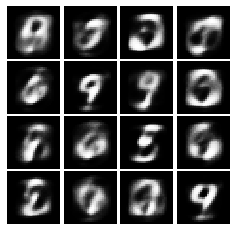

Iteration: 3100 - Discriminator Loss: 2.706, Generator Loss: -0.7094
Iteration: 3200 - Discriminator Loss: 2.73, Generator Loss: -0.7816
Iteration: 3300 - Discriminator Loss: 2.442, Generator Loss: -0.6876
Iteration: 3400 - Discriminator Loss: 2.407, Generator Loss: -0.657
Iteration: 3500 - Discriminator Loss: 2.537, Generator Loss: -0.6428
Iteration: 3600 - Discriminator Loss: 2.501, Generator Loss: -0.491
Iteration: 3700 - Discriminator Loss: 2.646, Generator Loss: -0.709
Iteration: 3800 - Discriminator Loss: 2.287, Generator Loss: -0.7422
Iteration: 3900 - Discriminator Loss: 2.353, Generator Loss: -0.6345
Iteration: 4000 - Discriminator Loss: 2.262, Generator Loss: -0.6024


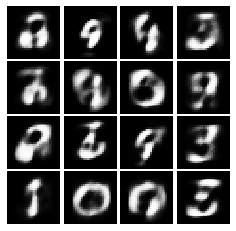

Iteration: 4100 - Discriminator Loss: 2.186, Generator Loss: -0.6669
Iteration: 4200 - Discriminator Loss: 2.241, Generator Loss: -0.7114
Iteration: 4300 - Discriminator Loss: 2.407, Generator Loss: -0.7237
Iteration: 4400 - Discriminator Loss: 2.006, Generator Loss: -0.7139
Iteration: 4500 - Discriminator Loss: 2.11, Generator Loss: -0.7679
Iteration: 4600 - Discriminator Loss: 1.995, Generator Loss: -0.5956
Iteration: 4700 - Discriminator Loss: 2.042, Generator Loss: -0.4872
Iteration: 4800 - Discriminator Loss: 2.172, Generator Loss: -0.7064
Iteration: 4900 - Discriminator Loss: 2.262, Generator Loss: -0.7165
Iteration: 5000 - Discriminator Loss: 2.399, Generator Loss: -0.7015


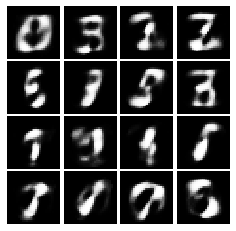

Iteration: 5100 - Discriminator Loss: 2.144, Generator Loss: -0.6525
Iteration: 5200 - Discriminator Loss: 2.21, Generator Loss: -0.611
Iteration: 5300 - Discriminator Loss: 2.127, Generator Loss: -0.7872
Iteration: 5400 - Discriminator Loss: 1.924, Generator Loss: -0.6807
Iteration: 5500 - Discriminator Loss: 2.15, Generator Loss: -0.7118
Iteration: 5600 - Discriminator Loss: 2.07, Generator Loss: -0.6094
Iteration: 5700 - Discriminator Loss: 1.949, Generator Loss: -0.7888
Iteration: 5800 - Discriminator Loss: 1.924, Generator Loss: -0.6108
Iteration: 5900 - Discriminator Loss: 2.183, Generator Loss: -0.7185
Iteration: 6000 - Discriminator Loss: 1.821, Generator Loss: -0.6384


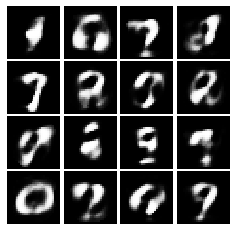

Iteration: 6100 - Discriminator Loss: 1.908, Generator Loss: -0.8334
Iteration: 6200 - Discriminator Loss: 1.834, Generator Loss: -0.5823
Iteration: 6300 - Discriminator Loss: 1.863, Generator Loss: -0.7263
Iteration: 6400 - Discriminator Loss: 1.973, Generator Loss: -0.7627
Iteration: 6500 - Discriminator Loss: 1.714, Generator Loss: -0.7897
Iteration: 6600 - Discriminator Loss: 1.922, Generator Loss: -0.7426
Iteration: 6700 - Discriminator Loss: 2.135, Generator Loss: -0.6593
Iteration: 6800 - Discriminator Loss: 1.959, Generator Loss: -0.5133
Iteration: 6900 - Discriminator Loss: 1.927, Generator Loss: -0.4737
Iteration: 7000 - Discriminator Loss: 1.908, Generator Loss: -0.7274


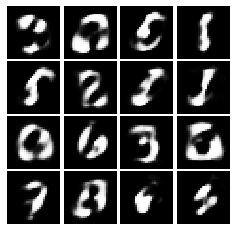

Iteration: 7100 - Discriminator Loss: 1.987, Generator Loss: -0.6524
Iteration: 7200 - Discriminator Loss: 1.95, Generator Loss: -0.6197
Iteration: 7300 - Discriminator Loss: 1.685, Generator Loss: -0.5597
Iteration: 7400 - Discriminator Loss: 1.892, Generator Loss: -0.6166
Iteration: 7500 - Discriminator Loss: 2.156, Generator Loss: -0.5705
Iteration: 7600 - Discriminator Loss: 1.74, Generator Loss: -0.6376
Iteration: 7700 - Discriminator Loss: 1.954, Generator Loss: -0.5276
Iteration: 7800 - Discriminator Loss: 2.121, Generator Loss: -0.6592
Iteration: 7900 - Discriminator Loss: 1.854, Generator Loss: -0.6272
Iteration: 8000 - Discriminator Loss: 1.64, Generator Loss: -0.5191


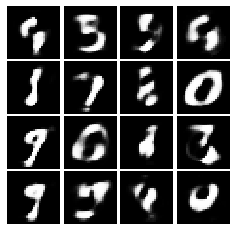

Iteration: 8100 - Discriminator Loss: 1.627, Generator Loss: -0.3377
Iteration: 8200 - Discriminator Loss: 2.153, Generator Loss: -0.5448
Iteration: 8300 - Discriminator Loss: 1.859, Generator Loss: -0.2635
Iteration: 8400 - Discriminator Loss: 1.666, Generator Loss: -0.2893
Iteration: 8500 - Discriminator Loss: 1.917, Generator Loss: -0.3611
Iteration: 8600 - Discriminator Loss: 1.86, Generator Loss: -0.4047
Iteration: 8700 - Discriminator Loss: 1.757, Generator Loss: -0.3186
Iteration: 8800 - Discriminator Loss: 1.841, Generator Loss: -0.09601
Iteration: 8900 - Discriminator Loss: 1.907, Generator Loss: -0.1513
Iteration: 9000 - Discriminator Loss: 1.909, Generator Loss: -0.2855


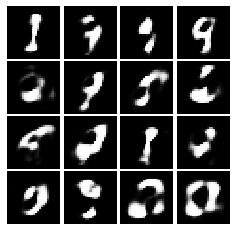

Iteration: 9100 - Discriminator Loss: 1.726, Generator Loss: -0.1874
Iteration: 9200 - Discriminator Loss: 1.811, Generator Loss: -0.03188
Iteration: 9300 - Discriminator Loss: 2.01, Generator Loss: -0.01769
Iteration: 9400 - Discriminator Loss: 1.778, Generator Loss: -0.1149
Iteration: 9500 - Discriminator Loss: 1.792, Generator Loss: 0.01482
Iteration: 9600 - Discriminator Loss: 1.757, Generator Loss: 0.02714
Iteration: 9700 - Discriminator Loss: 1.7, Generator Loss: 0.0006782
Iteration: 9800 - Discriminator Loss: 1.587, Generator Loss: 0.2475
Iteration: 9900 - Discriminator Loss: 1.635, Generator Loss: 0.02095
Iteration: 10000 - Discriminator Loss: 1.962, Generator Loss: 0.04795


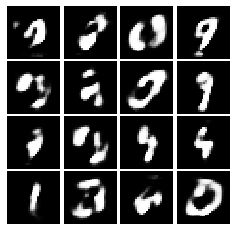

Iteration: 10100 - Discriminator Loss: 1.53, Generator Loss: 0.163
Iteration: 10200 - Discriminator Loss: 1.851, Generator Loss: 0.2086
Iteration: 10300 - Discriminator Loss: 1.736, Generator Loss: 0.1936
Iteration: 10400 - Discriminator Loss: 1.722, Generator Loss: -0.09443
Iteration: 10500 - Discriminator Loss: 1.883, Generator Loss: 0.07017
Iteration: 10600 - Discriminator Loss: 1.598, Generator Loss: 0.2354
Iteration: 10700 - Discriminator Loss: 1.648, Generator Loss: 0.1668
Iteration: 10800 - Discriminator Loss: 1.723, Generator Loss: 0.1072
Iteration: 10900 - Discriminator Loss: 1.625, Generator Loss: 0.2857
Iteration: 11000 - Discriminator Loss: 1.779, Generator Loss: 0.1687


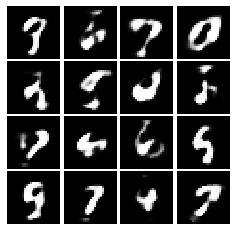

Iteration: 11100 - Discriminator Loss: 1.852, Generator Loss: 0.4718
Iteration: 11200 - Discriminator Loss: 1.695, Generator Loss: 0.2994
Iteration: 11300 - Discriminator Loss: 1.935, Generator Loss: 0.3879
Iteration: 11400 - Discriminator Loss: 1.928, Generator Loss: 0.518
Iteration: 11500 - Discriminator Loss: 1.793, Generator Loss: 0.4414
Iteration: 11600 - Discriminator Loss: 1.939, Generator Loss: 0.2814
Iteration: 11700 - Discriminator Loss: 1.726, Generator Loss: 0.6081
Iteration: 11800 - Discriminator Loss: 1.674, Generator Loss: 0.3474
Iteration: 11900 - Discriminator Loss: 1.751, Generator Loss: 0.3322
Iteration: 12000 - Discriminator Loss: 1.706, Generator Loss: 0.291


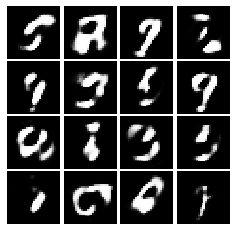

Iteration: 12100 - Discriminator Loss: 1.578, Generator Loss: 0.4913
Iteration: 12200 - Discriminator Loss: 1.838, Generator Loss: 0.4585
Iteration: 12300 - Discriminator Loss: 2.101, Generator Loss: 0.3419
Iteration: 12400 - Discriminator Loss: 1.916, Generator Loss: 0.7987
Iteration: 12500 - Discriminator Loss: 1.997, Generator Loss: 0.5326
Iteration: 12600 - Discriminator Loss: 1.825, Generator Loss: 1.027
Iteration: 12700 - Discriminator Loss: 1.726, Generator Loss: 0.9686
Iteration: 12800 - Discriminator Loss: 1.903, Generator Loss: 0.9907
Iteration: 12900 - Discriminator Loss: 1.995, Generator Loss: 1.199
Iteration: 13000 - Discriminator Loss: 1.8, Generator Loss: 1.002


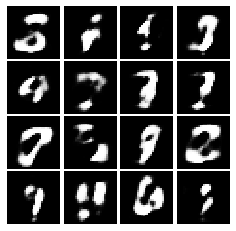

Iteration: 13100 - Discriminator Loss: 1.942, Generator Loss: 0.8351
Iteration: 13200 - Discriminator Loss: 2.231, Generator Loss: 1.055
Iteration: 13300 - Discriminator Loss: 2.485, Generator Loss: 0.8578
Iteration: 13400 - Discriminator Loss: 1.647, Generator Loss: 1.038
Iteration: 13500 - Discriminator Loss: 1.618, Generator Loss: 1.098
Iteration: 13600 - Discriminator Loss: 2.047, Generator Loss: 1.178
Iteration: 13700 - Discriminator Loss: 1.862, Generator Loss: 1.359
Iteration: 13800 - Discriminator Loss: 1.87, Generator Loss: 1.201
Iteration: 13900 - Discriminator Loss: 2.016, Generator Loss: 1.252
Iteration: 14000 - Discriminator Loss: 2.09, Generator Loss: 1.277


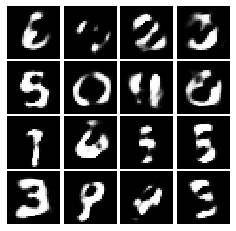

Iteration: 14100 - Discriminator Loss: 2.029, Generator Loss: 1.136
Iteration: 14200 - Discriminator Loss: 1.801, Generator Loss: 1.33
Iteration: 14300 - Discriminator Loss: 1.772, Generator Loss: 1.116
Iteration: 14400 - Discriminator Loss: 1.908, Generator Loss: 1.179
Iteration: 14500 - Discriminator Loss: 2.177, Generator Loss: 1.373
Iteration: 14600 - Discriminator Loss: 2.222, Generator Loss: 1.404
Iteration: 14700 - Discriminator Loss: 2.112, Generator Loss: 1.303
Iteration: 14800 - Discriminator Loss: 1.913, Generator Loss: 1.829
Iteration: 14900 - Discriminator Loss: 1.882, Generator Loss: 1.411
Iteration: 15000 - Discriminator Loss: 2.315, Generator Loss: 1.636


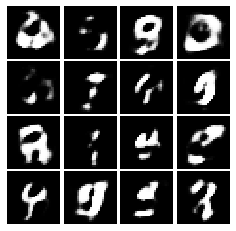

Iteration: 15100 - Discriminator Loss: 2.29, Generator Loss: 1.491
Iteration: 15200 - Discriminator Loss: 2.134, Generator Loss: 1.508
Iteration: 15300 - Discriminator Loss: 2.389, Generator Loss: 1.384
Iteration: 15400 - Discriminator Loss: 2.102, Generator Loss: 1.45
Iteration: 15500 - Discriminator Loss: 2.175, Generator Loss: 1.79
Iteration: 15600 - Discriminator Loss: 2.074, Generator Loss: 1.63
Iteration: 15700 - Discriminator Loss: 2.04, Generator Loss: 2.044
Iteration: 15800 - Discriminator Loss: 2.211, Generator Loss: 1.991
Iteration: 15900 - Discriminator Loss: 2.369, Generator Loss: 2.12
Iteration: 16000 - Discriminator Loss: 2.168, Generator Loss: 2.096


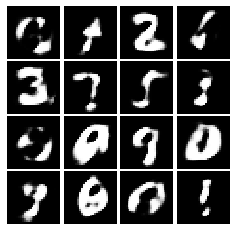

Iteration: 16100 - Discriminator Loss: 2.133, Generator Loss: 2.443
Iteration: 16200 - Discriminator Loss: 1.986, Generator Loss: 2.209
Iteration: 16300 - Discriminator Loss: 2.068, Generator Loss: 2.575
Iteration: 16400 - Discriminator Loss: 2.186, Generator Loss: 2.584
Iteration: 16500 - Discriminator Loss: 2.354, Generator Loss: 2.789
Iteration: 16600 - Discriminator Loss: 2.412, Generator Loss: 3.025
Iteration: 16700 - Discriminator Loss: 2.225, Generator Loss: 3.364
Iteration: 16800 - Discriminator Loss: 2.277, Generator Loss: 3.395
Iteration: 16900 - Discriminator Loss: 2.33, Generator Loss: 3.78
Iteration: 17000 - Discriminator Loss: 2.271, Generator Loss: 3.77


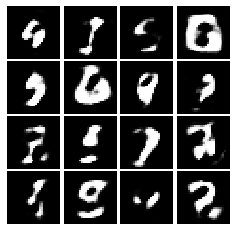

Iteration: 17100 - Discriminator Loss: 2.398, Generator Loss: 3.751
Iteration: 17200 - Discriminator Loss: 2.086, Generator Loss: 4.128
Iteration: 17300 - Discriminator Loss: 2.168, Generator Loss: 4.276
Iteration: 17400 - Discriminator Loss: 2.077, Generator Loss: 4.292
Iteration: 17500 - Discriminator Loss: 2.609, Generator Loss: 4.373
Iteration: 17600 - Discriminator Loss: 2.21, Generator Loss: 4.42
Iteration: 17700 - Discriminator Loss: 2.294, Generator Loss: 4.641
Iteration: 17800 - Discriminator Loss: 2.15, Generator Loss: 4.741
Iteration: 17900 - Discriminator Loss: 2.303, Generator Loss: 4.701
Iteration: 18000 - Discriminator Loss: 2.202, Generator Loss: 5.079


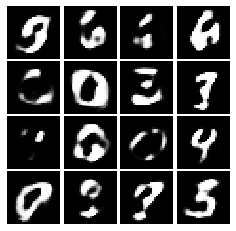

Iteration: 18100 - Discriminator Loss: 2.205, Generator Loss: 4.85
Iteration: 18200 - Discriminator Loss: 2.633, Generator Loss: 5.11
Iteration: 18300 - Discriminator Loss: 2.045, Generator Loss: 5.035
Iteration: 18400 - Discriminator Loss: 2.379, Generator Loss: 5.179
Iteration: 18500 - Discriminator Loss: 2.371, Generator Loss: 5.276
Iteration: 18600 - Discriminator Loss: 2.313, Generator Loss: 5.285
Iteration: 18700 - Discriminator Loss: 2.399, Generator Loss: 5.174
Iteration: 18800 - Discriminator Loss: 2.197, Generator Loss: 5.356
Iteration: 18900 - Discriminator Loss: 2.04, Generator Loss: 5.403
Iteration: 19000 - Discriminator Loss: 2.045, Generator Loss: 5.391


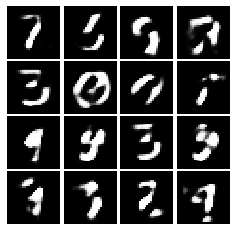

Iteration: 19100 - Discriminator Loss: 2.527, Generator Loss: 5.375
Iteration: 19200 - Discriminator Loss: 2.266, Generator Loss: 5.278
Iteration: 19300 - Discriminator Loss: 2.337, Generator Loss: 5.335
Iteration: 19400 - Discriminator Loss: 2.208, Generator Loss: 5.382
Iteration: 19500 - Discriminator Loss: 2.35, Generator Loss: 5.439
Iteration: 19600 - Discriminator Loss: 2.31, Generator Loss: 5.447
Iteration: 19700 - Discriminator Loss: 2.173, Generator Loss: 5.46
Iteration: 19800 - Discriminator Loss: 2.277, Generator Loss: 5.365
Iteration: 19900 - Discriminator Loss: 2.566, Generator Loss: 5.499
Iteration: 20000 - Discriminator Loss: 2.332, Generator Loss: 5.393


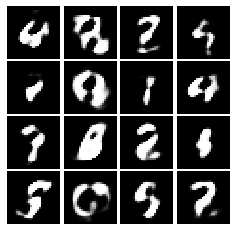

Iteration: 20100 - Discriminator Loss: 2.466, Generator Loss: 5.499
Iteration: 20200 - Discriminator Loss: 1.903, Generator Loss: 5.61
Iteration: 20300 - Discriminator Loss: 2.36, Generator Loss: 5.34
Iteration: 20400 - Discriminator Loss: 2.238, Generator Loss: 5.488
Iteration: 20500 - Discriminator Loss: 2.469, Generator Loss: 5.258
Iteration: 20600 - Discriminator Loss: 2.534, Generator Loss: 5.518
Iteration: 20700 - Discriminator Loss: 2.247, Generator Loss: 5.416
Iteration: 20800 - Discriminator Loss: 2.14, Generator Loss: 5.528
Iteration: 20900 - Discriminator Loss: 2.443, Generator Loss: 5.432
Iteration: 21000 - Discriminator Loss: 2.06, Generator Loss: 5.448


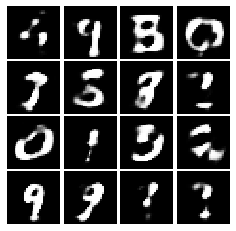

Iteration: 21100 - Discriminator Loss: 2.374, Generator Loss: 5.531
Iteration: 21200 - Discriminator Loss: 2.376, Generator Loss: 5.425
Iteration: 21300 - Discriminator Loss: 2.432, Generator Loss: 5.334
Iteration: 21400 - Discriminator Loss: 2.036, Generator Loss: 5.388
Iteration: 21500 - Discriminator Loss: 2.328, Generator Loss: 5.313
Iteration: 21600 - Discriminator Loss: 2.516, Generator Loss: 5.211
Iteration: 21700 - Discriminator Loss: 2.151, Generator Loss: 5.404
Iteration: 21800 - Discriminator Loss: 2.322, Generator Loss: 5.247
Iteration: 21900 - Discriminator Loss: 2.27, Generator Loss: 5.332
Iteration: 22000 - Discriminator Loss: 2.138, Generator Loss: 5.571


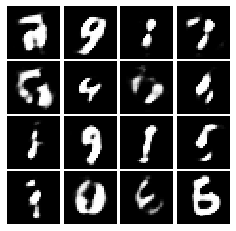

Iteration: 22100 - Discriminator Loss: 2.178, Generator Loss: 5.351
Iteration: 22200 - Discriminator Loss: 2.25, Generator Loss: 5.189
Iteration: 22300 - Discriminator Loss: 2.248, Generator Loss: 5.118
Iteration: 22400 - Discriminator Loss: 2.502, Generator Loss: 5.317
Iteration: 22500 - Discriminator Loss: 2.265, Generator Loss: 5.345
Iteration: 22600 - Discriminator Loss: 2.457, Generator Loss: 5.1
Iteration: 22700 - Discriminator Loss: 2.462, Generator Loss: 5.296
Iteration: 22800 - Discriminator Loss: 2.129, Generator Loss: 5.265
Iteration: 22900 - Discriminator Loss: 1.985, Generator Loss: 5.176
Iteration: 23000 - Discriminator Loss: 2.317, Generator Loss: 5.185


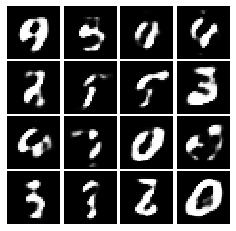

Iteration: 23100 - Discriminator Loss: 2.287, Generator Loss: 5.309
Iteration: 23200 - Discriminator Loss: 2.191, Generator Loss: 5.176
Iteration: 23300 - Discriminator Loss: 2.442, Generator Loss: 5.318
Iteration: 23400 - Discriminator Loss: 2.133, Generator Loss: 5.152
Iteration: 23500 - Discriminator Loss: 1.862, Generator Loss: 5.269
Iteration: 23600 - Discriminator Loss: 1.912, Generator Loss: 5.191
Iteration: 23700 - Discriminator Loss: 2.153, Generator Loss: 5.214
Iteration: 23800 - Discriminator Loss: 1.965, Generator Loss: 4.98
Iteration: 23900 - Discriminator Loss: 2.251, Generator Loss: 5.183
Iteration: 24000 - Discriminator Loss: 2.255, Generator Loss: 5.163


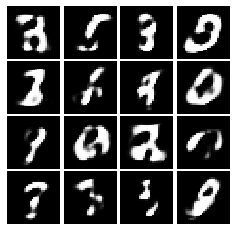

Iteration: 24100 - Discriminator Loss: 2.336, Generator Loss: 5.22
Iteration: 24200 - Discriminator Loss: 1.73, Generator Loss: 5.348
Iteration: 24300 - Discriminator Loss: 2.383, Generator Loss: 5.01
Iteration: 24400 - Discriminator Loss: 2.167, Generator Loss: 5.206
Iteration: 24500 - Discriminator Loss: 2.261, Generator Loss: 5.04
Iteration: 24600 - Discriminator Loss: 2.225, Generator Loss: 5.05
Iteration: 24700 - Discriminator Loss: 1.923, Generator Loss: 4.971
Iteration: 24800 - Discriminator Loss: 2.55, Generator Loss: 4.993
Iteration: 24900 - Discriminator Loss: 2.096, Generator Loss: 4.973
Iteration: 25000 - Discriminator Loss: 2.365, Generator Loss: 4.874


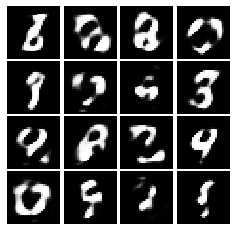

Iteration: 25100 - Discriminator Loss: 2.213, Generator Loss: 5.002
Iteration: 25200 - Discriminator Loss: 2.113, Generator Loss: 4.899
Iteration: 25300 - Discriminator Loss: 1.986, Generator Loss: 4.955
Iteration: 25400 - Discriminator Loss: 2.097, Generator Loss: 4.913
Iteration: 25500 - Discriminator Loss: 1.893, Generator Loss: 4.91
Iteration: 25600 - Discriminator Loss: 2.199, Generator Loss: 5.036
Iteration: 25700 - Discriminator Loss: 2.261, Generator Loss: 4.808
Iteration: 25800 - Discriminator Loss: 1.9, Generator Loss: 4.965
Iteration: 25900 - Discriminator Loss: 2.085, Generator Loss: 4.989
Iteration: 26000 - Discriminator Loss: 1.843, Generator Loss: 4.801


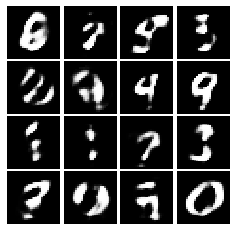

Iteration: 26100 - Discriminator Loss: 1.812, Generator Loss: 4.848
Iteration: 26200 - Discriminator Loss: 2.202, Generator Loss: 4.688
Iteration: 26300 - Discriminator Loss: 1.985, Generator Loss: 4.833
Iteration: 26400 - Discriminator Loss: 1.719, Generator Loss: 4.739
Iteration: 26500 - Discriminator Loss: 1.996, Generator Loss: 4.614
Iteration: 26600 - Discriminator Loss: 2.114, Generator Loss: 4.714
Iteration: 26700 - Discriminator Loss: 2.053, Generator Loss: 4.7
Iteration: 26800 - Discriminator Loss: 2.022, Generator Loss: 4.893
Iteration: 26900 - Discriminator Loss: 2.168, Generator Loss: 4.765
Iteration: 27000 - Discriminator Loss: 2.001, Generator Loss: 4.68


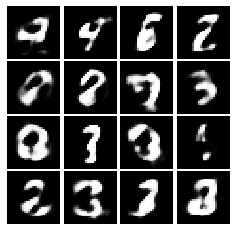

Iteration: 27100 - Discriminator Loss: 1.911, Generator Loss: 4.566
Iteration: 27200 - Discriminator Loss: 2.2, Generator Loss: 4.877
Iteration: 27300 - Discriminator Loss: 2.084, Generator Loss: 4.688
Iteration: 27400 - Discriminator Loss: 2.042, Generator Loss: 4.752
Iteration: 27500 - Discriminator Loss: 1.88, Generator Loss: 4.485
Iteration: 27600 - Discriminator Loss: 2.077, Generator Loss: 4.742
Iteration: 27700 - Discriminator Loss: 1.92, Generator Loss: 4.712
Iteration: 27800 - Discriminator Loss: 1.823, Generator Loss: 4.721
Iteration: 27900 - Discriminator Loss: 2.11, Generator Loss: 4.584
Iteration: 28000 - Discriminator Loss: 1.913, Generator Loss: 4.624


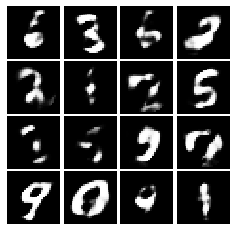

Iteration: 28100 - Discriminator Loss: 1.595, Generator Loss: 4.682
Iteration: 28200 - Discriminator Loss: 2.012, Generator Loss: 4.608
Iteration: 28300 - Discriminator Loss: 2.008, Generator Loss: 4.65
Iteration: 28400 - Discriminator Loss: 1.93, Generator Loss: 4.593
Iteration: 28500 - Discriminator Loss: 2.248, Generator Loss: 4.81
Iteration: 28600 - Discriminator Loss: 2.01, Generator Loss: 4.493
Iteration: 28700 - Discriminator Loss: 1.922, Generator Loss: 4.668
Iteration: 28800 - Discriminator Loss: 1.965, Generator Loss: 4.762
Iteration: 28900 - Discriminator Loss: 1.981, Generator Loss: 4.667
Iteration: 29000 - Discriminator Loss: 2.071, Generator Loss: 4.652


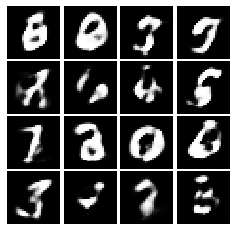

Iteration: 29100 - Discriminator Loss: 1.753, Generator Loss: 4.575
Iteration: 29200 - Discriminator Loss: 2.022, Generator Loss: 4.779
Iteration: 29300 - Discriminator Loss: 1.7, Generator Loss: 4.701
Iteration: 29400 - Discriminator Loss: 1.85, Generator Loss: 4.567
Iteration: 29500 - Discriminator Loss: 1.787, Generator Loss: 4.641
Iteration: 29600 - Discriminator Loss: 1.837, Generator Loss: 4.609
Iteration: 29700 - Discriminator Loss: 2.06, Generator Loss: 4.597
Iteration: 29800 - Discriminator Loss: 2.174, Generator Loss: 4.705
Iteration: 29900 - Discriminator Loss: 1.825, Generator Loss: 4.533
Iteration: 30000 - Discriminator Loss: 1.993, Generator Loss: 4.779


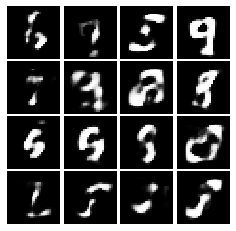

Iteration: 30100 - Discriminator Loss: 2.067, Generator Loss: 4.649
Iteration: 30200 - Discriminator Loss: 1.921, Generator Loss: 4.682
Iteration: 30300 - Discriminator Loss: 1.909, Generator Loss: 4.522
Iteration: 30400 - Discriminator Loss: 1.787, Generator Loss: 4.633
Iteration: 30500 - Discriminator Loss: 2.023, Generator Loss: 4.465
Iteration: 30600 - Discriminator Loss: 1.771, Generator Loss: 4.614
Iteration: 30700 - Discriminator Loss: 2.111, Generator Loss: 4.5
Iteration: 30800 - Discriminator Loss: 1.817, Generator Loss: 4.574
Iteration: 30900 - Discriminator Loss: 2.028, Generator Loss: 4.467
Iteration: 31000 - Discriminator Loss: 1.766, Generator Loss: 4.519


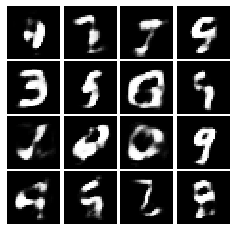

Iteration: 31100 - Discriminator Loss: 2.028, Generator Loss: 4.553
Iteration: 31200 - Discriminator Loss: 1.826, Generator Loss: 4.591
Iteration: 31300 - Discriminator Loss: 1.934, Generator Loss: 4.589
Iteration: 31400 - Discriminator Loss: 2.182, Generator Loss: 4.594
Iteration: 31500 - Discriminator Loss: 1.918, Generator Loss: 4.53
Iteration: 31600 - Discriminator Loss: 1.928, Generator Loss: 4.628
Iteration: 31700 - Discriminator Loss: 1.904, Generator Loss: 4.452
Iteration: 31800 - Discriminator Loss: 1.929, Generator Loss: 4.505
Iteration: 31900 - Discriminator Loss: 1.908, Generator Loss: 4.658
Iteration: 32000 - Discriminator Loss: 2.124, Generator Loss: 4.577


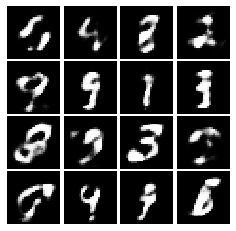

Iteration: 32100 - Discriminator Loss: 1.806, Generator Loss: 4.584
Iteration: 32200 - Discriminator Loss: 2.037, Generator Loss: 4.435
Iteration: 32300 - Discriminator Loss: 2.042, Generator Loss: 4.403
Iteration: 32400 - Discriminator Loss: 1.689, Generator Loss: 4.47
Iteration: 32500 - Discriminator Loss: 2.148, Generator Loss: 4.384
Iteration: 32600 - Discriminator Loss: 1.824, Generator Loss: 4.411
Iteration: 32700 - Discriminator Loss: 1.917, Generator Loss: 4.275
Iteration: 32800 - Discriminator Loss: 1.85, Generator Loss: 4.319
Iteration: 32900 - Discriminator Loss: 2.051, Generator Loss: 4.243
Iteration: 33000 - Discriminator Loss: 1.836, Generator Loss: 4.403


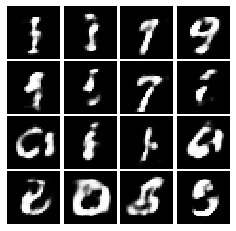

Iteration: 33100 - Discriminator Loss: 2.007, Generator Loss: 4.364
Iteration: 33200 - Discriminator Loss: 1.932, Generator Loss: 4.366
Iteration: 33300 - Discriminator Loss: 2.206, Generator Loss: 4.088
Iteration: 33400 - Discriminator Loss: 1.816, Generator Loss: 4.615
Iteration: 33500 - Discriminator Loss: 1.801, Generator Loss: 4.144
Iteration: 33600 - Discriminator Loss: 1.443, Generator Loss: 4.319
Iteration: 33700 - Discriminator Loss: 1.659, Generator Loss: 4.256
Iteration: 33800 - Discriminator Loss: 1.65, Generator Loss: 4.346
Iteration: 33900 - Discriminator Loss: 1.773, Generator Loss: 4.215
Iteration: 34000 - Discriminator Loss: 1.766, Generator Loss: 4.057


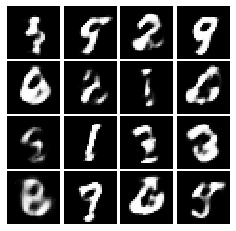

Iteration: 34100 - Discriminator Loss: 1.616, Generator Loss: 4.292
Iteration: 34200 - Discriminator Loss: 1.738, Generator Loss: 4.324
Iteration: 34300 - Discriminator Loss: 1.562, Generator Loss: 4.286
Iteration: 34400 - Discriminator Loss: 1.621, Generator Loss: 4.286
Iteration: 34500 - Discriminator Loss: 1.794, Generator Loss: 4.091
Iteration: 34600 - Discriminator Loss: 1.744, Generator Loss: 4.141
Iteration: 34700 - Discriminator Loss: 1.821, Generator Loss: 4.228
Iteration: 34800 - Discriminator Loss: 1.745, Generator Loss: 4.077
Iteration: 34900 - Discriminator Loss: 1.766, Generator Loss: 4.172
Iteration: 35000 - Discriminator Loss: 1.568, Generator Loss: 4.159


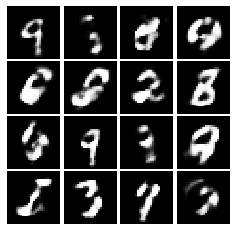

Iteration: 35100 - Discriminator Loss: 1.696, Generator Loss: 4.12
Iteration: 35200 - Discriminator Loss: 1.985, Generator Loss: 3.97
Iteration: 35300 - Discriminator Loss: 1.772, Generator Loss: 4.091
Iteration: 35400 - Discriminator Loss: 1.772, Generator Loss: 4.039
Iteration: 35500 - Discriminator Loss: 1.777, Generator Loss: 4.06
Iteration: 35600 - Discriminator Loss: 1.765, Generator Loss: 4.279
Iteration: 35700 - Discriminator Loss: 1.79, Generator Loss: 4.266
Iteration: 35800 - Discriminator Loss: 1.752, Generator Loss: 4.133
Iteration: 35900 - Discriminator Loss: 1.816, Generator Loss: 3.976
Iteration: 36000 - Discriminator Loss: 1.749, Generator Loss: 3.928


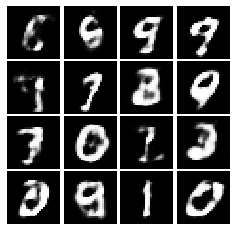

Iteration: 36100 - Discriminator Loss: 2.056, Generator Loss: 4.058
Iteration: 36200 - Discriminator Loss: 1.873, Generator Loss: 4.15
Iteration: 36300 - Discriminator Loss: 1.738, Generator Loss: 4.168
Iteration: 36400 - Discriminator Loss: 1.837, Generator Loss: 4.013
Iteration: 36500 - Discriminator Loss: 1.996, Generator Loss: 3.977
Iteration: 36600 - Discriminator Loss: 1.506, Generator Loss: 3.899
Iteration: 36700 - Discriminator Loss: 1.769, Generator Loss: 4.066
Iteration: 36800 - Discriminator Loss: 1.828, Generator Loss: 3.889
Iteration: 36900 - Discriminator Loss: 1.817, Generator Loss: 4.137
Iteration: 37000 - Discriminator Loss: 1.805, Generator Loss: 4.01


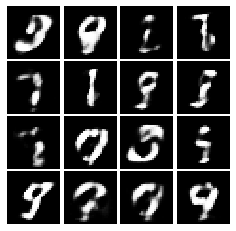

Iteration: 37100 - Discriminator Loss: 1.885, Generator Loss: 3.98
Iteration: 37200 - Discriminator Loss: 1.803, Generator Loss: 3.927
Iteration: 37300 - Discriminator Loss: 1.951, Generator Loss: 3.872
Iteration: 37400 - Discriminator Loss: 1.843, Generator Loss: 3.848
Iteration: 37500 - Discriminator Loss: 1.883, Generator Loss: 4.022
Iteration: 37600 - Discriminator Loss: 1.691, Generator Loss: 4.016


In [0]:
for i in range(100000):
    for _ in range(n_disc):
        x_batch, _ = mnist.train.next_batch(batch_size)

        _, d_loss_val = sess.run(
            [d_step, d_loss],
            feed_dict={X: x_batch, z: get_sample_z(size=(batch_size, z_dim))}
        )

    _, g_loss_val = sess.run(
        [g_step, g_loss],
        feed_dict={z: get_sample_z(size=(batch_size, z_dim))}
    )

    if i % 100 == 0:
        print('Iteration: {} - Discriminator Loss: {:.4}, Generator Loss: {:.4}'
              .format(i, -d_loss_val, g_loss_val))

        if i % 1000 == 0:
            samples = sess.run(generator_sample, feed_dict={z: get_sample_z(size=(16, z_dim))})

            fig = plot_images(samples)
            plot.show()
            i += 1
            plot.close(fig)